This notebook is for taking our transformer models and applying SHAP explanations to their output to see which tokens contribute to what.

In [6]:
from torch.utils.data import DataLoader
from dataset.phishing_dataset import PhishingDataset

from classifiers.basic_url_skinny_bert_classifier import BasicUrlSkinnyBertClassifier
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer
import shap
import scipy as sp
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = BasicUrlSkinnyBertClassifier()
checkpoint_path = "../models/canonical/basic_url_skinny_bert_phishing_classifier_epoch_1.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

dataset_path = os.path.expanduser("~/transfer/phishing_output_tokenized.h5")
test_dataset = PhishingDataset(['url'], split='dev', local_file_path=dataset_path)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Define a wrapper for SHAP compatibility
class BertClassifierWrapper(nn.Module):
    def __init__(self, model):
        super(BertClassifierWrapper, self).__init__()
        self.model = model

    def forward(self, tokenized_inputs):
        input_ids = tokenized_inputs.to(device)
        attention_mask = (input_ids != 0).long().to(device)
        return self.model(input_ids, attention_mask)

wrapped_model = BertClassifierWrapper(model)

# prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, max_length=128, padding='max_length', truncation=True) for v in x])
    class_preds = wrapped_model(tv)
    outputs = class_preds.detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])
    return val

batch = test_dataloader.__iter__().__next__()
explainer = shap.Explainer(f, tokenizer)
urls = batch['url']
shap_values = explainer(urls, fixed_context=1)



/var/folders/j1/dctzbvps2w7cgcp3cflmcxm00000gn/T/ipykernel_76972/148017162.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_p

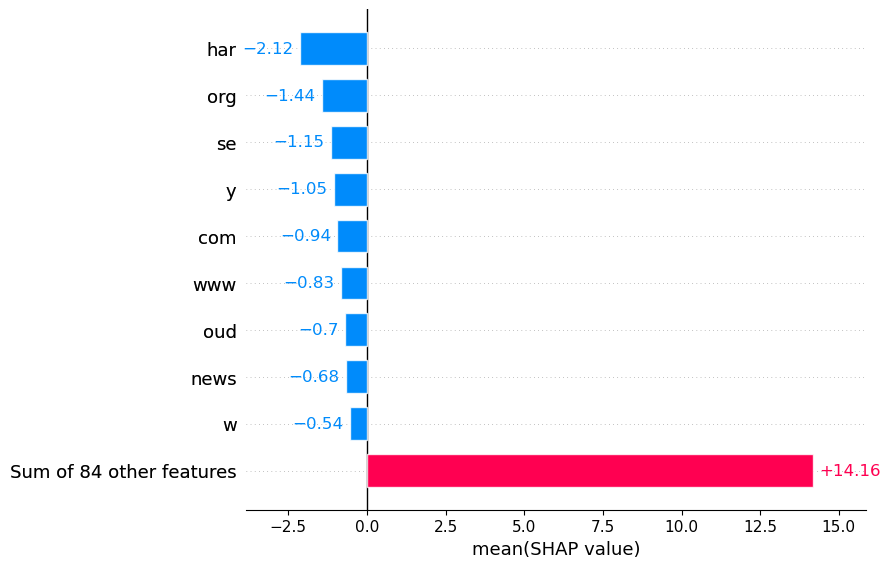

In [14]:
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort)